# Imports

In [19]:
import numpy as np
import matplotlib.pyplot as plt
from rkstiff.grids import construct_x_kx_rfft
from rkstiff.derivatives import dx_rfft
from rkstiff.if34 import IF34
from rkstiff.etd35 import ETD35
%matplotlib inline

# Helper graph functions

In [15]:
def plotResults(u0,uf,u0FFT,ufFFT):
    """
    Helper function that plots initial 1D-array along with final propagated result.
    Also plots the initial spectral (fft) 1D-array along with final propagated spectral result.
    
    INPUTS
        u0 - initial 1D-array
        uf - final propagated 1D-array
        u0FFT - initial spectral 1D-array
        uFFT - final propagated spectral 1D-array
        
    """
    
    fig = plt.figure(figsize=(12,8))
    ax1 = fig.add_subplot(2,2,1)
    ax2 = fig.add_subplot(2,2,2,sharey = ax1)
    ax3 = fig.add_subplot(2,2,3)
    ax4 = fig.add_subplot(2,2,4,sharey = ax3)
    ax1.plot(x,u0)
    ax2.plot(x,uf)
    ax3.plot(kx,np.abs(u0FFT)**2)
    ax4.plot(kx,np.abs(ufFFT)**2)
    ax3.set_yscale('log')
    ax4.set_yscale('log')
    fig.tight_layout()
    
    
def waterfall(x,t,u,**kwargs):
    if 'figsize' in kwargs:
        fig = plt.figure(figsize=kwargs['figsize'])
    else:
        fig = plt.figure(figsize=(6,6))
    ax = fig.add_subplot(1,1,1,projection='3d')
    ax.w_xaxis.set_pane_color((0,0,0,0))
    ax.w_yaxis.set_pane_color((0,0,0,0))
    ax.w_zaxis.set_pane_color((0,0,0,0))
    for i,snapshot in enumerate(u):
        ax.plot(x,t[i]*np.ones_like(x),snapshot,color='black')
    plt.xlim([x[0],x[-1]])
    plt.ylim([t[0],t[-1]])
    plt.tight_layout()
    return ax

# Construct grids

In [2]:
# uniform grid spacing, field assumed to be real-valued -> construct_x_kx_rfft
N = 8192
a,b = -np.pi, np.pi
x,kx = construct_x_kx_rfft(N,a,b)

# Linear and nonlinear functions for Burgers equation

In [3]:
mu = 0.0005
L = -mu*kx**2
def NL(uf):
    u = np.fft.irfft(uf)
    ux = np.fft.irfft(1j*kx*uf)
    return -np.fft.rfft(u*ux)

# Initial field to be propagated

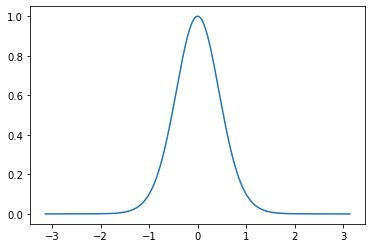

In [4]:
u0 = np.exp(-10*np.sin(x/2)**2)
u0FFT = np.fft.rfft(u0)
plt.plot(x,u0)

# Initialize IF34 solver

In [6]:
solver = IF34(linop=L,NLfunc=NL,epsilon=1e-8)

# Propagate step by step

tf =  1.0000687748719552


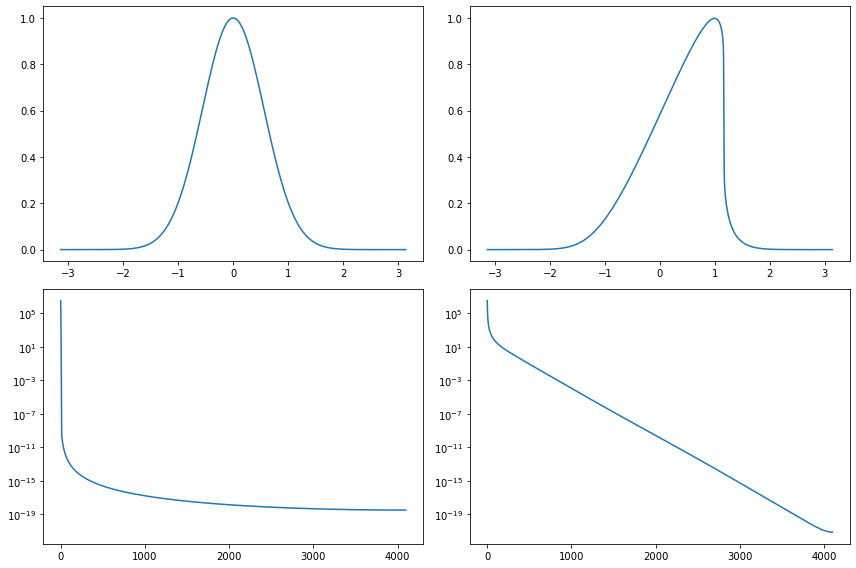

In [17]:
h = 0.01
uFFT = u0FFT.copy()
t = 0
while t < 1:
    uFFT,h,h_suggest = solver.step(uFFT,h)
    t += h
    # use suggested step (or not for a constant step size scheme)
    h = h_suggest  
    
print('tf = ',t)
uf = np.fft.irfft(uFFT)
plotResults(u0,uf,u0FFT,uFFT)

# Propagate from time t0 to tf

In [13]:
# store_data -> propagated field stored in solver.u at times solver.t 
# store_freq -> propagated field values stored on every store_freq step (default is every step)
uFFT = solver.evolve(u0FFT,t0=0,tf=1,store_data=True,store_freq=50)

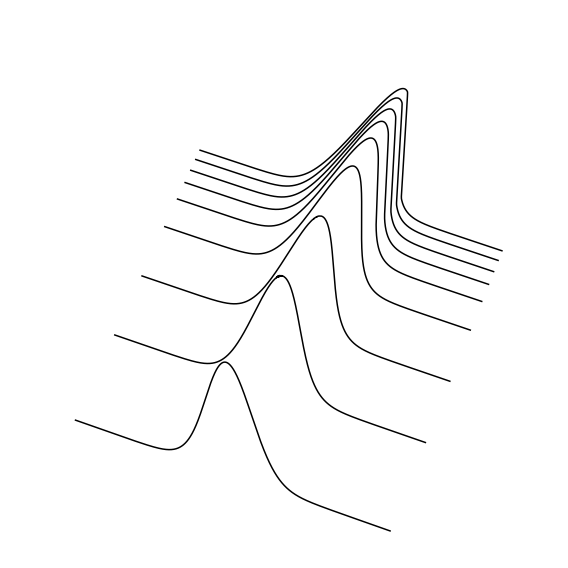

In [10]:
U = []
for u in solver.u:
    U.append(np.fft.irfft(u))
U = np.array(U)
t = np.array(solver.t)
ax = waterfall(x,t,U,figsize=(8,8))
ax.grid(False)
ax.axis(False)
ax.view_init(62,-69)

In [11]:
mu = 0.0005
L = -mu*kx**2
def NLfunc(uf):
    u = np.fft.irfft(uf)
    ux = np.fft.irfft(1j*kx*uf)
    return -np.fft.rfft(u*ux)

u0 = np.exp(-10*x**2/(b-a))
u0FFT = np.fft.rfft(u0)
t0, tf = 0,0.4

tf =  0.4000000000000003


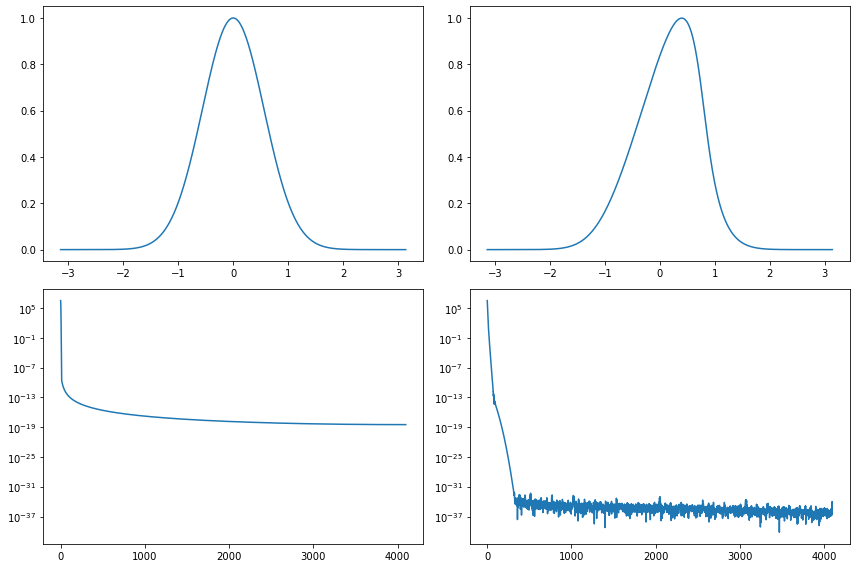

In [48]:
solver = ETD35(linop=L,NLfunc=NL,epsilon=1)
solver.adapt_modecutoff = 0.001
h = 0.002
tf = 0.4
total_steps = int(tf/h)
uFFT = u0FFT.copy()
t = 0
numsteps = 0
while numsteps < total_steps:
    uFFT,h_new,h_suggest = solver.step(uFFT,h)
    assert h_new == h
    t += h
    numsteps += 1  
    
print('tf = ',t)
uf = np.fft.irfft(uFFT)
plotResults(u0,uf,u0FFT,uFFT)